<div>
<a href="http://www.music-processing.de/"><img style="float:left;" src="../data/FMP_Teaser_Cover.png" width=40% alt="FMP"></a>
<a href="https://www.audiolabs-erlangen.de"><img src="../data/Logo_AudioLabs_Long.png" width=59% style="float: right;" alt="AudioLabs"></a>
</div>

<div>
<a href="../C1/C1.html"><img src="../data/C1_nav.png" width="100"  style="float:right;" alt="C1"></a>
<h1>Symbolic Format: CSV</h1>        
</div>

<br />

<p>
Following Section 1.2 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>, we introduce in this notebook at a simple symbolic music representation encoded in some comma-separated values (CSV) format.
</p> 

## CSV Format

Recall that a [piano-roll representation](../C1/C1S1_SheetMusic.html) yields a visualization of note events, where each note is encoded by a start, duration, and pitch parameter. Further parameters could encode a note's velocity, articulation, or instrumentation. In the following, we introduce a simple format stored in a comma-separated values (CSV) file. Each note event corresponds to a line encoding a data record consisting of the four parameters `start`, `duration`, `pitch`, `velocity`, and `label`. The first four parameters are real numbers and encode the start (given in seconds or measures), duration (given in seconds or measures), pitch (encoded as MIDI note number), and velocity (in the range between 0.0 and 1.0) of a note event. The last parameter `label` is a string that my encode further information such as the instrument (e.g. violin, trumpet, flute), the voice (e.g. soprano, alto, tenor and bass), or some staff information (e.g. left/right hand for a piano score). In the following, we use the first five measures of Symphony No. 5 by Ludwig van Beethoven in a piano reduced version as a running example.

<img src="../data/C1/FMP_C1_F01.png" width="300px" align="middle" alt="C1">

A CSV file of a piano-roll representation of this score looks as follows:

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches
import pandas as pd
import IPython.display as ipd

%matplotlib inline

fn = os.path.join('..', 'data', 'C1', 'FMP_C1_F01_Beethoven_FateMotive_Sibelius.csv')

with open(fn, 'r', encoding='utf-8') as file:
    csv_str = file.read()

print(csv_str)

"Start";"Duration";"Pitch";"Velocity";"Label"
0.25;0.23;67.0;1.0;"Right Hand"
0.25;0.23;55.0;1.0;"Right Hand"
0.25;0.23;43.0;1.0;"Left Hand"
0.5;0.23;67.0;1.0;"Right Hand"
0.5;0.23;55.0;1.0;"Right Hand"
0.5;0.23;43.0;1.0;"Left Hand"
0.75;0.23;67.0;1.0;"Right Hand"
0.75;0.23;55.0;1.0;"Right Hand"
0.75;0.23;43.0;1.0;"Left Hand"
1.0;0.97;63.0;1.0;"Right Hand"
1.0;0.97;51.0;1.0;"Right Hand"
1.0;0.97;39.0;1.0;"Left Hand"
2.25;0.23;65.0;1.0;"Right Hand"
2.25;0.23;53.0;1.0;"Right Hand"
2.25;0.23;41.0;1.0;"Left Hand"
2.5;0.23;65.0;1.0;"Right Hand"
2.5;0.23;53.0;1.0;"Right Hand"
2.5;0.23;41.0;1.0;"Left Hand"
2.75;0.23;65.0;1.0;"Right Hand"
2.75;0.23;53.0;1.0;"Right Hand"
2.75;0.23;41.0;1.0;"Left Hand"
3.0;1.97;62.0;1.0;"Right Hand"
3.0;1.97;50.0;1.0;"Left Hand"
3.0;1.97;38.0;1.0;"Left Hand"



## Python Library `pandas`

The Python library [`pandas`](https://pandas.pydata.org/) provides easy-to-use data structures and data analysis tools. In particular, it can be used to easily read and modify CSV files. When reading a CSV file, the content is stored in a two-dimensional tabular data structure with labeled axes (rows and columns) called `DataFrame`. This data structure can be accessed using attributes, see the [documentation for `pandas.DataFrame`](http://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html). We apply `pandas` to our previous example and print the first four rows.

In [2]:
df = pd.read_csv(fn, sep=';')
print(df.loc[0:5,:])

   Start  Duration  Pitch  Velocity       Label
0   0.25      0.23   67.0       1.0  Right Hand
1   0.25      0.23   55.0       1.0  Right Hand
2   0.25      0.23   43.0       1.0   Left Hand
3   0.50      0.23   67.0       1.0  Right Hand
4   0.50      0.23   55.0       1.0  Right Hand
5   0.50      0.23   43.0       1.0   Left Hand


The `pandas`-library allows for rendering a `DataFrame` as an HTML table as shown in the next example. 

In [3]:
html = df.loc[0:5,:].to_html(index=False)
ipd.HTML(html)

Start,Duration,Pitch,Velocity,Label
0.25,0.23,67.0,1.0,Right Hand
0.25,0.23,55.0,1.0,Right Hand
0.25,0.23,43.0,1.0,Left Hand
0.50,0.23,67.0,1.0,Right Hand
0.50,0.23,55.0,1.0,Right Hand
0.50,0.23,43.0,1.0,Left Hand


## Piano-Roll Visualization

The note events stored in the CSV file can be visualized using a piano-roll representation. The following functions illustrates how this may be done. Note that the color of a rectangle is used to indicated the different labels associated to note events. 

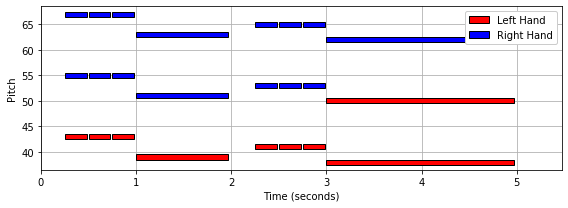

In [4]:
import sys
sys.path.append('..')
from libfmp.b import color_argument_to_dict

def csv_to_list(csv):
    """Convert a csv score file to a list of note events

    Notebook: C1/C1S2_CSV.ipynb

    Args:
        csv: Either a path to a csv file or a data frame

    Returns:
        score: A list of note events where each note is specified as 
        [start, duration, pitch, velocity, label]
    """

    if isinstance(csv, str):
        df = read_csv(csv)
    elif isinstance(csv, pd.DataFrame):
        df = csv
    else:
        raise RuntimeError('csv must be a path to a csv file or pd.DataFrame')

    score = []
    for i, (start, duration, pitch, velocity, label) in df.iterrows():
        score.append([start, duration, pitch, velocity, label])
    return score

def visualize_piano_roll(score, xlabel='Time (seconds)', ylabel='Pitch', colors='FMP_1', velocity_alpha=False,
                         figsize=(12, 4), ax=None, dpi=72):
    """Plot a pianoroll visualization

    Notebook: C1/C1S2_CSV.ipynb

    Args:
        score: List of note events
        xlabel: Label for x axis
        ylabel: Label for y axis
        colors: Several options: 1. string of FMP_COLORMAPS, 2. string of matplotlib colormap, 3. list or np.ndarray of
            matplotlib color specifications, 4. dict that assigns labels  to colors
        velocity_alpha (bool): Use the velocity value for the alpha value of the corresponding rectangle
        figsize: Width, height in inches
        ax: The Axes instance to plot on
        dpi: Dots per inch

    Returns:
        fig: The created matplotlib figure or None if ax was given.
        ax: The used axes
    """
    fig = None
    if ax is None:
        fig = plt.figure(figsize=figsize, dpi=dpi)
        ax = plt.subplot(1, 1, 1)

    labels_set = sorted(set([note[4] for note in score]))
    colors = color_argument_to_dict(colors, labels_set)

    pitch_min = min(note[2] for note in score)
    pitch_max = max(note[2] for note in score)
    time_min = min(note[0] for note in score)
    time_max = max(note[0] + note[1] for note in score)

    for start, duration, pitch, velocity, label in score:
        rect = patches.Rectangle((start, pitch - 0.5), duration, 1, linewidth=1,
                                 edgecolor='k', facecolor=colors[label], alpha=velocity)
        ax.add_patch(rect)

    ax.set_ylim([pitch_min - 1.5, pitch_max + 1.5])
    ax.set_xlim([min(time_min, 0), time_max + 0.5])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid()
    ax.set_axisbelow(True)
    ax.legend([patches.Patch(linewidth=1, edgecolor='k', facecolor=colors[key]) for key in labels_set],
              labels_set, loc='upper right', framealpha=1)

    if fig is not None:
        plt.tight_layout()

    return fig, ax

score = csv_to_list(df)
visualize_piano_roll(score, colors=['red','blue'], figsize=(8, 3));

## Piano-Roll Representation for Orchestral Version

The next example shows a piano-roll representation for a full orchestral score of the first 21 measures of Beethoven's Fifth, see [the notebook on sheet music representations](../C1S1_SheetMusic.html). Note that note events that overlap in the time&ndash;pitch domain are painted over by the visualization function in a greedy fashion.

<img src="../data/C1/FMP_C1_F10_Beethoven_Fifth-MM1-20_Sibelius-Orchestra.png" width="700px" align="left" alt="C1">
<br clear="all" />
<audio src="../data/C1/FMP_C1_F10_Beethoven_Fifth-MM1-20_Sibelius-Orchestra-Fast.mp3" type="audio/mpeg" controls="controls"></audio>

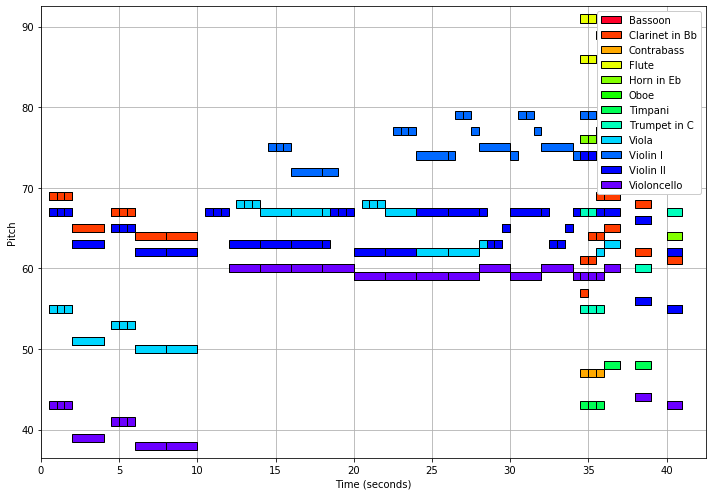

In [5]:
fn = os.path.join('..', 'data', 'C1', 'FMP_C1_F10_Beethoven_Fifth-MM1-20_Sibelius-Orchestra.csv')

df = pd.read_csv(fn, sep=';')
score_list = csv_to_list(df)
visualize_piano_roll(score_list, figsize=(10, 7), colors='gist_rainbow');

## Piano Roll Representation for Fugue

The next example shows a piano-roll representation of the beginning of the four-voice Fugue BWV 846 in C major by Johann Sebastian Bach. The four different voices are labeled with 'Soprano', 'Alto', 'Tenor', and 'Basso'.

<img src="../data/C1/FMP_C1_F12_Bach_BWV846_SheetMusic.png" width="700px" align="left" alt="C1">
<br clear="all" />
<audio src="../data/C1/FMP_C1_F12_Bach_BWV846.mp3" type="audio/mpeg" controls="controls"></audio>

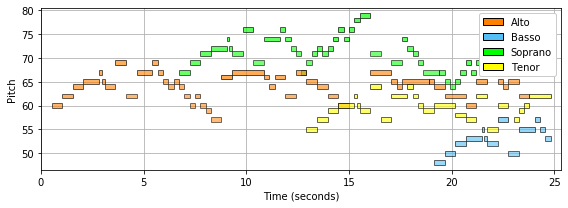

In [6]:
fn = os.path.join('..', 'data', 'C1', 'FMP_C1_F12_Bach_BWV846_Sibelius-Tracks.csv')

df = pd.read_csv(fn, sep=';')
score_list = csv_to_list(df)
visualize_piano_roll(score_list, figsize=(8, 3));

#output_path_filename = os.path.join('..', 'output', 'C1', 'FMP_C1_F12_Bach_BWV846_PianoRoll.png')
#plt.savefig(output_path_filename)

## Further Notes

The functions to convert a csv file to a list of note events as well as the pianoroll visualiztion function have been included into libfmp. In the following code cell, we call those `libfmp` functions:

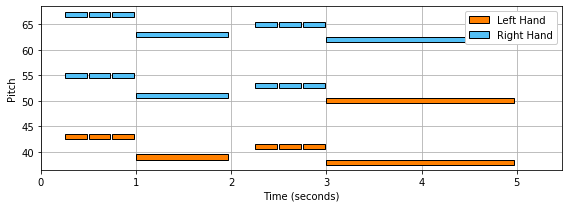

In [7]:
import sys
sys.path.append('..')
import libfmp.c1

fn = os.path.join('..', 'data', 'C1', 'FMP_C1_F01_Beethoven_FateMotive_Sibelius.csv')
score = libfmp.c1.csv_to_list(fn)
libfmp.c1.visualize_piano_roll(score, figsize=(8, 3));

<div class="alert" style="background-color:#F5F5F5; border-color:#C8C8C8">
<strong>Acknowledgment:</strong> This notebook was created by <a href="https://www.audiolabs-erlangen.de/fau/assistant/zalkow">Frank Zalkow</a> and <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller">Meinard Müller</a>.
</div>  

<table style="border:none">
<tr style="border:none">
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C0/C0.html"><img src="../data/C0_nav.png" style="height:50px" alt="C0"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C1/C1.html"><img src="../data/C1_nav.png" style="height:50px" alt="C1"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C2/C2.html"><img src="../data/C2_nav.png" style="height:50px" alt="C2"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C3/C3.html"><img src="../data/C3_nav.png" style="height:50px" alt="C3"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C4/C4.html"><img src="../data/C4_nav.png" style="height:50px" alt="C4"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C5/C5.html"><img src="../data/C5_nav.png" style="height:50px" alt="C5"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C6/C6.html"><img src="../data/C6_nav.png" style="height:50px" alt="C6"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C7/C7.html"><img src="../data/C7_nav.png" style="height:50px" alt="C7"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C8/C8.html"><img src="../data/C8_nav.png" style="height:50px" alt="C8"></a></td>
</tr>
</table>